In [34]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import least_squares

#problema 1

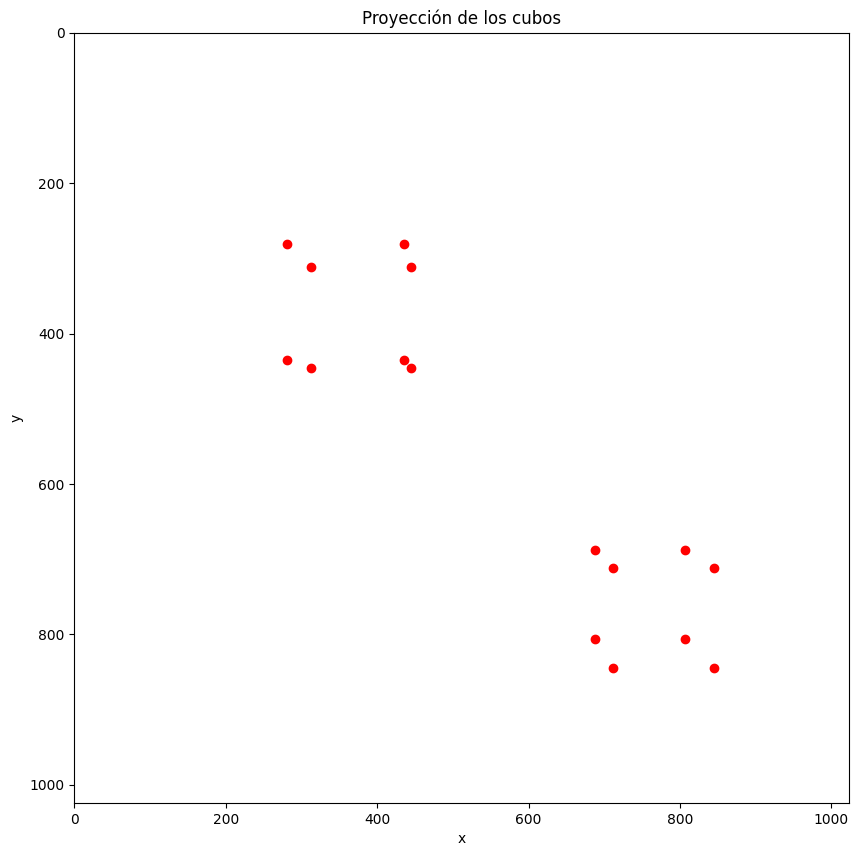

In [35]:
#primero definamos dos cubos
def cubos(centro, tamaño):
    x, y, z = centro
    t = tamaño/2.0
    return np.array([[ x - t, y - t, z - t],
                     [ x + t, y - t, z- t], 
                     [x + t, y + t, z - t], 
                     [x + t, y - t, z + t], 
                     [x -t, y + t, z - t], 
                     [x - t, y + t, z +t ], 
                     [x - t, y - t, z + t],
                     [x + t, y + t, z + t]
                     ])

#luego nuestros dos cubos
cubo_1 = cubos(np.array([-1, -1, 1]), 1)
cubo_2 = cubos(np.array([2, 2, 2]), 1)
cubos_3d = np.vstack([cubo_1, cubo_2])

#ahora definiremos la cámara intrínseca y extrínsca
#por lo que
f = 1000 # longitud focal
c = np.array([512, 512]) #centro de la imagen
K = np.array([[f, 0, c[0]], 
              [0, f, c[1]], 
              [0, 0, 1]
              ]) #cámara estandar pinhole matriz

#luego los parámetros extrínsecos
#matriz de rotación
R = np.eye(3)
t = np.array([[0], 
             [0], 
             [6]])
#luego la matriz P
Rt = np.hstack([R, t])
P = np.dot(K, Rt) #mi mtriz de proyección

#luego nuestros puntos a coordenadas homogéneas
cubos_homogéneos = np.hstack([cubos_3d, np.ones((cubos_3d.shape[0], 1))])

#PROYECTAMOS
puntos_proyectados_homogéneos = (P @ cubos_homogéneos.T).T
puntos_proyectados = puntos_proyectados_homogéneos[:, :2] / puntos_proyectados_homogéneos[:, 2:3]

#ploteamos los puntos
plt.figure(figsize=(10, 10))    
plt.scatter(puntos_proyectados[:, 0], puntos_proyectados[:, 1], color='r')
plt.xlim(0, 1024)
plt.ylim(0, 1024)
plt.gca().invert_yaxis()
plt.title('Proyección de los cubos')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [36]:
##Problema 2
#ahora añadiremos perturbacones a las coordenadas de los puntos proyectadpos 
#como a continuación 
m, sigma = 0.0, 1.0
samples = np.random.normal(m, sigma, puntos_proyectados.shape)
print(samples)

[[ 0.66281584 -0.23077957]
 [-0.26761786  2.35651356]
 [ 1.43842068  1.17711333]
 [-0.90594976 -1.07321412]
 [ 0.66789884  1.82219698]
 [-0.76632869 -0.0326889 ]
 [ 0.1670596  -0.79193817]
 [-1.31452651  0.99564185]
 [-0.00700011 -0.58109136]
 [-0.46548883 -1.20940371]
 [-0.43517587 -1.03951488]
 [-0.12365225 -0.19459398]
 [ 0.0827002   0.29690683]
 [ 0.39897611  0.2520437 ]
 [-0.03483126 -0.7780698 ]
 [ 0.89534817 -2.17687904]]


[ 0.05383897 -0.77148336  1.47141816  1.44063934  0.41984891 -0.59253902
 -0.62943113 -0.084922   -0.88955871 -0.95082479 -1.11682778  1.14114664
  0.67049004  0.36342041  1.01365589 -0.55964293 -1.53367721 -0.60218419
 -0.37810144 -0.93923534 -0.12325429  0.13426334 -0.35567754  0.84691785
  0.77454228  1.22288507  0.35883844 -0.80937198 -0.98404551  0.05946041
  0.22817393  0.24319948]


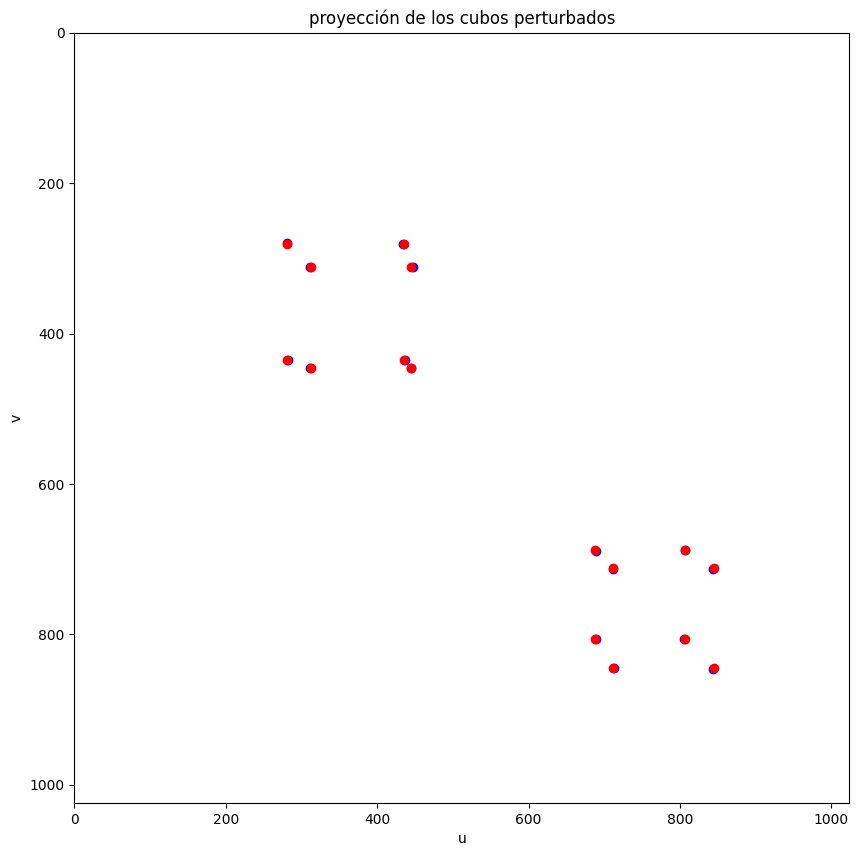

In [37]:
##Problema 2
#ahora añadiremos perturbacones a las coordenadas de los puntos proyectadpos 
#como a continuación 
m, sigma = 0.0, 1.0
samples = np.random.normal(m, sigma, 32)
print(samples)
#vamos a tomar los 32 valores de los samples y generar el nuevo de conjunto de puntos trasladados
ruido_en_x = samples[:16] #primeros 16 valores
ruido_en_y = samples[16:] #últimos 16 valores
puntos_proyectados_perturbados = puntos_proyectados.copy()
#vamos a sumarle la perturbación a cada punto
puntos_proyectados_perturbados[:, 0] += ruido_en_x
puntos_proyectados_perturbados[:, 1] += ruido_en_y

#print(puntos_proyectados_perturbados)
#segunda perturbación
samples = np.random.normal(10, 5, 32)
ruido_x_2 = samples[:16]
ruido_y_2 = samples[16:]
puntos_proyectados_perturbados_2 = puntos_proyectados.copy()
puntos_proyectados_perturbados_2[:, 0] += ruido_x_2
puntos_proyectados_perturbados_2[:, 1] += ruido_y_2


#ploteamos los puntos
plt.figure(figsize=(10, 10))    
plt.scatter(puntos_proyectados_perturbados[:, 0], puntos_proyectados_perturbados[:, 1], color='b')
plt.scatter(puntos_proyectados[:, 0], puntos_proyectados[:, 1], color='r')
#plt.scatter(puntos_proyectados_perturbados_2[:, 0], puntos_proyectados_perturbados_2[:, 1], color='g')
plt.xlim(0, 1024)
plt.ylim(0, 1024)
plt.gca().invert_yaxis()
plt.title('proyección de los cubos perturbados')
plt.xlabel('u')
plt.ylabel('v')
plt.show()

#problema 3
 Use the 16 correspondences $(p_{k}^i, p_{k}^m)$ and the DLT algorithm seen in the class to obtain an estimate P^* of the projection matrix. This will imply constructing the data matrix D and apply an eigen-decomposition of D⊤D. You can use the version of the eigendecomposition
 present in numpy, an example is given below.

In [38]:
#normalizar puntos (usaremos esto para la construcción de D)
def normalizar_puntos_3d(puntos):
    centroide = np.mean(puntos, axis=0)
    distancias = np.linalg.norm(puntos - centroide, axis=1)
    escala = np.sqrt(3) / np.mean(distancias)

    puntos_normalizados = (puntos - centroide) * escala
    T_3d = np.eye(4)
    T_3d[:3, :3] *= escala
    T_3d[:3, 3] = -escala * centroide

    return puntos_normalizados, T_3d

def normalizar_puntos_2d(puntos):
    centroide = np.mean(puntos, axis=0)
    distancias = np.linalg.norm(puntos - centroide, axis=1)
    escala = np.sqrt(2) / np.mean(distancias)

    puntos_normalizados = (puntos - centroide) * escala
    T_2d = np.eye(3)
    T_2d[:2, :2] *= escala
    T_2d[:2, 2] = -escala * centroide

    return puntos_normalizados, T_2d


In [39]:
p_k_i = puntos_proyectados.copy()
p_k_m = cubos_3d.copy()
print(p_k_i)
print(p_k_m)

[[281.23076923 281.23076923]
 [435.07692308 281.23076923]
 [435.07692308 435.07692308]
 [445.33333333 312.        ]
 [281.23076923 435.07692308]
 [312.         445.33333333]
 [312.         312.        ]
 [445.33333333 445.33333333]
 [712.         712.        ]
 [845.33333333 712.        ]
 [845.33333333 845.33333333]
 [806.11764706 688.47058824]
 [712.         845.33333333]
 [688.47058824 806.11764706]
 [688.47058824 688.47058824]
 [806.11764706 806.11764706]]
[[-1.5 -1.5  0.5]
 [-0.5 -1.5  0.5]
 [-0.5 -0.5  0.5]
 [-0.5 -1.5  1.5]
 [-1.5 -0.5  0.5]
 [-1.5 -0.5  1.5]
 [-1.5 -1.5  1.5]
 [-0.5 -0.5  1.5]
 [ 1.5  1.5  1.5]
 [ 2.5  1.5  1.5]
 [ 2.5  2.5  1.5]
 [ 2.5  1.5  2.5]
 [ 1.5  2.5  1.5]
 [ 1.5  2.5  2.5]
 [ 1.5  1.5  2.5]
 [ 2.5  2.5  2.5]]


In [40]:

#y normalizamos
p_k_i_normalizados, T_2d = normalizar_puntos_2d(p_k_i)
p_k_m_normalizados, T_3d = normalizar_puntos_3d(p_k_m)

#print(p_k_i_normalizados)
#print(p_k_m_normalizados)


In [41]:

#convertimos a coordenadas homogeneas
p_k_i_normalizados_homogeneas = np.hstack([p_k_i_normalizados, np.ones((p_k_i_normalizados.shape[0], 1))])
p_k_m_normalizados_homogeneas = np.hstack([p_k_m_normalizados, np.ones((p_k_m_normalizados.shape[0], 1))])

#print(p_k_i_normalizados_homogeneas)
#print(p_k_m_normalizados_homogeneas)


In [42]:
#construimos D
D =[]
for i in range(len(p_k_i_normalizados_homogeneas)):
    u_k, v_k, _ = p_k_i_normalizados_homogeneas[i]
    p_k_m_i = p_k_m_normalizados_homogeneas[i]
    fila_1 = np.hstack([p_k_m_i,np.zeros(4), -u_k*p_k_m_i])
    fila_2 = np.hstack([np.zeros(4), p_k_m_i,-v_k*p_k_m_i])
    
    #apprend
    D.append(fila_1)
    D.append(fila_2)
    
D = np.array(D)
print(D.shape)
print(D)

(32, 12)
[[-1.51058021 -1.51058021 -0.75529011  1.          0.          0.
   0.          0.         -2.11797569 -2.11797569 -1.05898784  1.40209416]
 [ 0.          0.          0.          0.         -1.51058021 -1.51058021
  -0.75529011  1.         -2.11797569 -2.11797569 -1.05898784  1.40209416]
 [-0.75529011 -1.51058021 -0.75529011  1.          0.          0.
   0.          0.         -0.48625847 -0.97251694 -0.48625847  0.64380357]
 [ 0.          0.          0.          0.         -0.75529011 -1.51058021
  -0.75529011  1.         -1.05898784 -2.11797569 -1.05898784  1.40209416]
 [-0.75529011 -0.75529011 -0.75529011  1.          0.          0.
   0.          0.         -0.48625847 -0.48625847 -0.48625847  0.64380357]
 [ 0.          0.          0.          0.         -0.75529011 -0.75529011
  -0.75529011  1.         -0.48625847 -0.48625847 -0.48625847  0.64380357]
 [-0.75529011 -1.51058021  0.          1.          0.          0.
   0.          0.         -0.44807651 -0.89615302  0.  

In [43]:
#ahora construiremos D^TD para aplicar una eigen descomposición con SVD
DtD = np.dot(D.T, D)
print(DtD.shape)
print(DtD)

eigenvalores, eigenvectores = np.linalg.eig(DtD)
print("\n")
print("Los eigen valores son:")
print(eigenvalores)

(12, 12)
[[ 2.28185258e+01  2.05366732e+01  6.84555773e+00  1.55431223e-15
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.05348351e-01  1.52674175e-01  5.39448753e-01 -1.96300186e+01]
 [ 2.05366732e+01  2.28185258e+01  6.84555773e+00  1.55431223e-15
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.52674175e-01 -5.60810513e-15  4.37665969e-01 -1.76265888e+01]
 [ 6.84555773e+00  6.84555773e+00  4.56370515e+00  2.22044605e-16
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   5.39448753e-01  4.37665969e-01  2.91777313e-01 -5.79467367e+00]
 [ 1.55431223e-15  1.55431223e-15  2.22044605e-16  1.60000000e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.96300186e+01 -1.76265888e+01 -5.79467367e+00 -2.88657986e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.28185258e+01  2.05366732e+01  6.84555773e+00  1.55431223e-15
  -6.05219434e-15  1.52674175e-01  4.37665969e-01 -1.76265888e+

In [44]:
#construcción de P estrella
P_estrella = eigenvectores[:, np.argmin(eigenvalores)].reshape(3, 4)
print("\n")
print("La matriz P estimada es:")
print(P_estrella)




La matriz P estimada es:
[[ 5.44043171e-01 -4.67810658e-16 -2.92125745e-02  3.99754485e-02]
 [ 3.25171001e-16  5.44043171e-01 -2.92125745e-02  3.99754485e-02]
 [-1.19447442e-15  6.98587798e-16  1.10378463e-01  6.25258210e-01]]


#Problema 4
Deduce estimates for the intrinsic/extrinsic parameters K_gorro, R_gorro, t_gorro. Explain how you have raised the ambiguity over the extrinsic parameters.

In [45]:
#Primero podemos ver la forma de P^* =[ A| b] donde A 3x3 y b 3x1
#por lo que tomemos dichos valores
A_estrella = P_estrella[:, :3]
b_estrella = P_estrella[:, 3]
print("\n")
print(A_estrella)
print("\n")
print(b_estrella)



[[ 5.44043171e-01 -4.67810658e-16 -2.92125745e-02]
 [ 3.25171001e-16  5.44043171e-01 -2.92125745e-02]
 [-1.19447442e-15  6.98587798e-16  1.10378463e-01]]


[0.03997545 0.03997545 0.62525821]


In [46]:
#recuperando los parámetros tenemos
lambda_ = 1/np.linalg.norm(A_estrella[:, 2])
lambda_2 = -1* ( 1/np.linalg.norm(A_estrella[:, 2]))
print(lambda_)
r3 = lambda_ * A_estrella[:, 2]
print("El valor de r3 =", r3)
u_0 = lambda_**2 * np.dot(A_estrella[:, 0], A_estrella[:, 2])

print("u_0 =", u_0)

v_0 = lambda_**2 * np.dot(A_estrella[:, 1], A_estrella[:, 2])
print("v_0 =", v_0)
a1xa3 =  np.cross(A_estrella[:, 0], A_estrella[:, 2])
a2xa3 = np.cross(A_estrella[:, 1], A_estrella[:, 2])
norma_a1xa3 = np.linalg.norm(a1xa3)
norma_a2xa3 = np.linalg.norm(a2xa3)

print("a1xa3 =", a1xa3)
print("a2xa3 =", a2xa3)
print("||a1xa3|| =", norma_a1xa3)
print("||a2xa3|| = ", norma_a2xa3)
cos_theta = -1*np.dot(a1xa3, a2xa3)/(norma_a1xa3*norma_a2xa3)
print("cos_theta =", cos_theta)
theta = np.arccos(cos_theta)
print("theta = ", theta)
theta_degrees = theta*180/np.pi
print("theta_deg =", theta_degrees)
alpha_u = lambda_**2 * norma_a1xa3 * np.sin(theta)
print("alpha_u =", alpha_u)
alpha_v = lambda_**2 * norma_a2xa3 * np.sin(theta)
print("alpha_v = ", alpha_v)
r1 = a2xa3 / norma_a2xa3
print("r1 = ", r1)
r2 = np.cross(r3, r1)
print("r2 = ", r2)


8.484894884869302
El valor de r3 = [-0.24786562 -0.24786562  0.93654966]
u_0 = -1.1441846813322822
v_0 = -1.1441846813322694
a1xa3 = [ 9.98202439e-19 -6.00506493e-02 -1.58929017e-02]
a2xa3 = [6.00506493e-02 3.12286736e-17 1.58929017e-02]
||a1xa3|| = 0.062118151925523855
||a2xa3|| =  0.06211815192552384
cos_theta = 0.0654589958914724
theta =  1.5052904932095632
theta_deg = 86.24679220207408
alpha_u = 4.462508027715451
alpha_v =  4.46250802771545
r1 =  [9.66716610e-01 5.02730242e-16 2.55849557e-01]
r2 =  [-0.06341631  0.96879442  0.23961582]


In [47]:
#construyamos k
K = np.array([
        [alpha_u, -alpha_u * np.cos(theta) / np.sin(theta), u_0],
        [0, alpha_v / np.sin(theta), v_0],
        [0, 0, 1]])
print("K =")
print( K)
print("\n")
K_inversa = np.linalg.inv(K)
print("K_inversa =")
print(K_inversa)
#finalmente t
t = lambda_* np.dot(K_inversa, b_estrella)
print("\n")
print("t = ", t)

t_2 = lambda_2* np.dot(K_inversa, b_estrella)
print("\n")
print("t (para lambda_2) = ", t_2)

K =
[[ 4.46250803 -0.29273914 -1.14418468]
 [ 0.          4.47209952 -1.14418468]
 [ 0.          0.          1.        ]]


K_inversa =
[[0.22408923 0.01466866 0.27318312]
 [0.         0.22360862 0.25584956]
 [0.         0.         1.        ]]


t =  [1.53028848 1.43319115 5.30525019]


t (para lambda_2) =  [-1.53028848 -1.43319115 -5.30525019]


In [48]:
R = []
R =np.column_stack((r1, r2, r3))
print("R = ")
print(R)
np.linalg.det(R)

R = 
[[ 9.66716610e-01 -6.34163101e-02 -2.47865624e-01]
 [ 5.02730242e-16  9.68794422e-01 -2.47865624e-01]
 [ 2.55849557e-01  2.39615816e-01  9.36549660e-01]]


np.float64(1.0)

#¿Ambiguedad?
Usamos el signo que haga que la cámara esté orietada bien con la escena, i.e, que los puntos 3D proyectados
se proyecten en la parte frontal de la imagen.

#problema 5

In [49]:
P_estrella_normalizada = P_estrella
#desnormalizamos la P_estrella
P_real = np.linalg.inv(T_2d) @ P_estrella_normalizada @ T_3d

In [50]:
#y construimos nuestro vector psi
psi = P_real.flatten()[:11]/P_real[2, 3]

In [51]:
def error_de_reproyeccion(psi, puntos_3d, puntos_2d_ruido):
    P = np.append(psi, 1).reshape(3, 4)
    errores = []
    
    for i in range(len(puntos_3d)):
        puntos_3d_homogeneos = np.append(puntos_3d[i], 1)
        
        #luego proyectamos con la P que construimos a partir de psi
        puntos_proyectados = P@puntos_3d_homogeneos
        u_proyectado = puntos_proyectados[0]/puntos_proyectados[2]
        v_proyectado = puntos_proyectados[1]/puntos_proyectados[2]
        
        #lurgo la distancia
        u_ruido, v_ruido = puntos_2d_ruido[i]
        suma_cuadrados = (u_proyectado - u_ruido)**2 + (v_proyectado - v_ruido)**2
        error = np.sqrt(suma_cuadrados)
        errores.append(error)
        
    #luego promediamos el error
    error_promedio = np.mean(errores)
    
    return error_promedio

In [52]:
error_de_reproyeccion(psi, cubos_3d, puntos_proyectados_perturbados)

np.float64(1.0550263874334542)

#Problema 6
Study experimentally the influence of the number of points used for the estimation in question 3 on the obtained average reprojection error:
To do so, repeat the estimation before with random subsets of the points with increasing cardinal and evaluate D(psi) in each case.
You can use several subsets for one cardinal value and give the average reprojection error.




In [ ]:
#primero una función para automatizar la construcción de D
def construir_D(p_k_i_normalizados_homogeneas, p_k_m_normalizados_homogeneas):
    D = []
    for i in range(len(p_k_i_normalizados_homogeneas)):
        u_k, v_k, _ = p_k_i_normalizados_homogeneas[i]
        p_k_m_i = p_k_m_normalizados_homogeneas[i]

        fila_1 = np.hstack([p_k_m_i, np.zeros(4), -u_k * p_k_m_i])
        fila_2 = np.hstack([np.zeros(4), p_k_m_i, -v_k * p_k_m_i])

        D.append(fila_1)
        D.append(fila_2)

    D = np.array(D)
    DtD = np.dot(D.T, D)

    return D, DtD


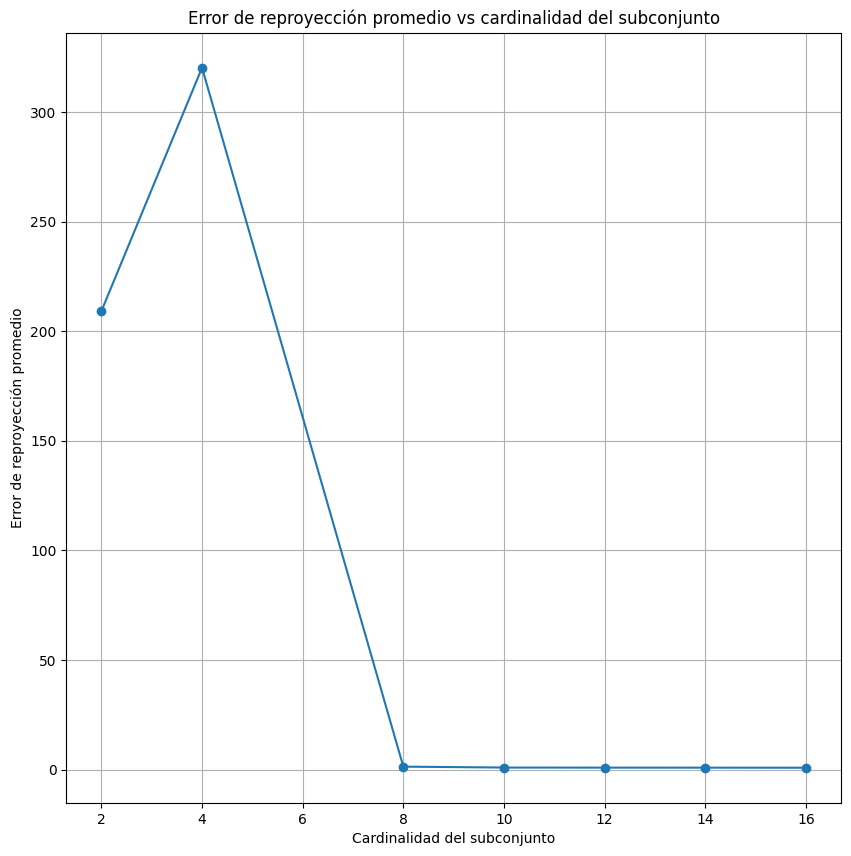

In [54]:
cardinales = [2, 4, 8, 10, 12, 14,  16]
numero_repeticiones = 5
errores_promedios = []

for cantidad in cardinales:
    errores_repeticiones = []
    for _ in range(numero_repeticiones):
        #primero el subconjunto de puntos
        indices = random.sample(range(len(cubos_3d)), cantidad)
        subconjunto_de_cubos_3d = cubos_3d[indices]
        subconjunto_de_puntos_proyectados = puntos_proyectados_perturbados[indices]
        
        #ahora a normalizar
        subconjunto_de_puntos_proyectados_normalizados, T_2d = normalizar_puntos_2d(subconjunto_de_puntos_proyectados)
        subconjunto_de_cubos_3d_normalizados, T_3d = normalizar_puntos_3d(subconjunto_de_cubos_3d)
        
        #homogeneizamos los puntos
        subconjunto_de_puntos_proyectados_normalizados_homo= np.hstack([subconjunto_de_puntos_proyectados_normalizados, np.ones((subconjunto_de_puntos_proyectados_normalizados.shape[0], 1))])
        subconjunto_de_cubos_3d_homo = np.hstack([subconjunto_de_cubos_3d_normalizados, np.ones((subconjunto_de_cubos_3d_normalizados.shape[0], 1))])
        #mandamos a construir D
        
        D, DtD = construir_D(subconjunto_de_puntos_proyectados_normalizados_homo, subconjunto_de_cubos_3d_homo)
        #print(DtD)
        #print(D)
    
        eigenvalores, eigenvectores = np.linalg.eig(DtD)
        P_estrella = eigenvectores[:, np.argmin(eigenvalores)].reshape(3, 4)
         
        #desnormalizamos la P_estrella
        P_real = np.linalg.inv(T_2d) @ P_estrella @ T_3d
        psi = P_real.flatten()[:11] / P_real[2, 3]
        error = error_de_reproyeccion(psi, cubos_3d, puntos_proyectados_perturbados)
        #guardamos
        errores_repeticiones.append(error)
        
    #calculamos el promedio
    error_promedio = np.real(np.mean(errores_repeticiones))
    errores_promedios.append(error_promedio)




    
#y graficamos
plt.figure(figsize=(10, 10))
plt.plot(cardinales, errores_promedios, marker='o')
plt.title('Error de reproyección promedio vs cardinalidad del subconjunto')
plt.xlabel('Cardinalidad del subconjunto')
plt.ylabel('Error de reproyección promedio')
plt.grid()
plt.show()
        
        
        

In [55]:
print("Vamos a ver los tamaños de los errores promedios")
for cantidad, error in zip(cardinales, errores_promedios):
    print(f"Cardinalidad {cantidad} ==> Error promedio: {error:.3f} píxeles")

Vamos a ver los tamaños de los errores promedios
Cardinalidad 2 ==> Error promedio: 209.176 píxeles
Cardinalidad 4 ==> Error promedio: 320.263 píxeles
Cardinalidad 8 ==> Error promedio: 1.346 píxeles
Cardinalidad 10 ==> Error promedio: 0.932 píxeles
Cardinalidad 12 ==> Error promedio: 0.894 píxeles
Cardinalidad 14 ==> Error promedio: 0.875 píxeles
Cardinalidad 16 ==> Error promedio: 0.852 píxeles


problema 7
Study experimentally the influence of the noise level (sigma) over the obtained reprojection error.

In [56]:
#crearemos un arreglo para todas nuestras sigmas

sigmas_arreglos = [1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0]
numero_de_repeticiones = 6
errores_promedios_sigmas = []
print(sigmas_arreglos) 

[1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0]


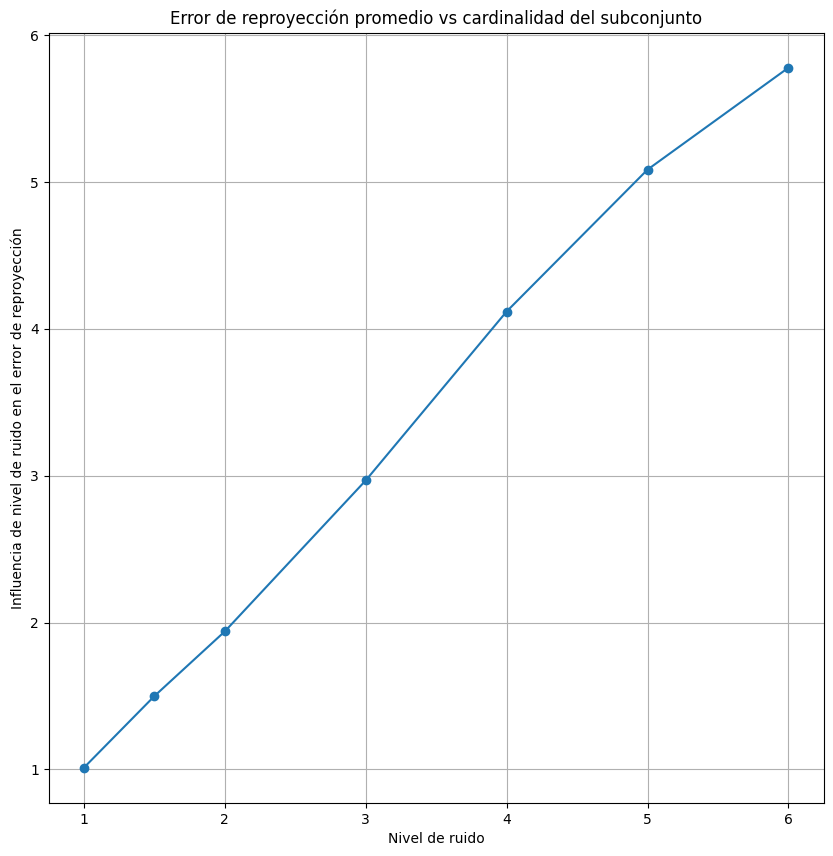

In [57]:
for sigma in sigmas_arreglos:
    errores_repeticiones = []
    for _ in range(numero_de_repeticiones):
        #vamos a añadir ruido con cada uno de los sigmas nuevos
        m = 0 # usamos el mismo m que usamos la primera vez que añadimos ruido
        puntos_proyectados_ruido = puntos_proyectados.copy()
        #añadimos ruido
        samples = np.random.normal(m, sigma, 32)
        ruido_en_x = samples[:16]
        ruido_en_y = samples[16:]
        puntos_proyectados_ruido[:, 0] += ruido_en_x
        puntos_proyectados_ruido[:, 1] += ruido_en_y
        
        #normalizamos
        puntos_proyectados_normalizados, T_2d = normalizar_puntos_2d(puntos_proyectados_ruido)
        puntos_3d_normalizados, T_3d = normalizar_puntos_3d(cubos_3d)
        
        #homogeneizamos
        puntos_proyectados_normalizados_homogeneas = np.hstack([puntos_proyectados_normalizados, np.ones((puntos_proyectados_normalizados.shape[0], 1))])
        puntos_3d_normalizados_homogeneas = np.hstack([puntos_3d_normalizados, np.ones((puntos_3d_normalizados.shape[0], 1))])
        
        #construir D
        D, DtD = construir_D(puntos_proyectados_normalizados_homogeneas, puntos_3d_normalizados_homogeneas)
        eigenvalores, eigenvectores = np.linalg.eig(DtD)
        P_estrella = eigenvectores[:, np.argmin(eigenvalores)].reshape(3, 4)
        
        #desnormalizamos la P encontrada
        P_real = np.linalg.inv(T_2d) @ P_estrella @ T_3d
        psi = P_real.flatten()[:11] / P_real[2, 3]
        
        #llamamos la función de error
        error = error_de_reproyeccion(psi, cubos_3d, puntos_proyectados_ruido)
        errores_repeticiones.append(error)
        
    #promediamos
    error_promedio = np.real(np.mean(errores_repeticiones))
    errores_promedios_sigmas.append(error_promedio)
    
#nuevamente vamos a graficar
#y graficamos
plt.figure(figsize=(10, 10))
plt.plot(sigmas_arreglos, errores_promedios_sigmas, marker='o')
plt.title('Error de reproyección promedio vs cardinalidad del subconjunto')
plt.xlabel('Nivel de ruido')
plt.ylabel('Influencia de nivel de ruido en el error de reproyección')
plt.grid()
plt.show()
    
        

    
        
        
        

In [58]:
#imprimimos los valores de los errores promedios
print("Vamos a ver los tamaños de los errores promedios")
for sigma, error in zip(sigmas_arreglos, errores_promedios_sigmas):
    print(f"Sigma {sigma} ==> Error promedio: {error:.3f} píxeles")


Vamos a ver los tamaños de los errores promedios
Sigma 1.0 ==> Error promedio: 1.012 píxeles
Sigma 1.5 ==> Error promedio: 1.499 píxeles
Sigma 2.0 ==> Error promedio: 1.940 píxeles
Sigma 3.0 ==> Error promedio: 2.968 píxeles
Sigma 4.0 ==> Error promedio: 4.118 píxeles
Sigma 5.0 ==> Error promedio: 5.084 píxeles
Sigma 6.0 ==> Error promedio: 5.778 píxeles


In [59]:
print(sigmas_arreglos)
print(errores_promedios_sigmas)

[1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0]
[np.float64(1.0117920070124529), np.float64(1.499170131679455), np.float64(1.9398095463142504), np.float64(2.967834142219198), np.float64(4.118290800687366), np.float64(5.084375700977376), np.float64(5.7783277310787495)]


#problema 8
use the least_squares function from the scipy.optimize package to implement a non-linear least-square parameter refinement, over the intrinsic and extrinsic parameters, starting from the estimates from question 4.

In [60]:
#vamos a mandar a llamar a K, R y t para construir P
P_prob8= K @ np.hstack((R, t.reshape(3, 1)))
print(P_prob8)

[[ 4.02124149 -0.84076459 -2.10512814  0.33918748]
 [-0.29273914  4.05838032 -2.18006551  0.33918748]
 [ 0.25584956  0.23961582  0.93654966  5.30525019]]


In [61]:
#error por punto
errores = []
for i in range(len(cubos_3d)):
    #homogeneizamos puntos
    puntos_3d_homo = cubos_3d.copy() #aqui no estan homogeneizados
    #ahora sí homoegeneizamos
    puntos_3d_homo = np.append(puntos_3d_homo[i], 1)
    puntos_proyectados_prob8 = P_prob8@ puntos_3d_homo
    
    #extraemos coordenadas u y v para cada punto en cada repetición
    u_proyectado = puntos_proyectados_prob8[0] / puntos_proyectados_prob8[2]
    v_proyectado = puntos_proyectados_prob8[1] / puntos_proyectados_prob8[2]
    
    u_ruido, v_ruido = puntos_proyectados_perturbados[i] #usamos los primeros puntos con ruido que usamos en la tarea
    
    errores.append(u_proyectado - u_ruido)
    errores.append(v_proyectado - v_ruido)
    
print(errores)
print(len(errores)) #tenemos 32 elementos en esta lista




[np.float64(-282.37481406100585), np.float64(-280.96923736841575), np.float64(-434.5821710086678), np.float64(-281.8945371281434), np.float64(-436.96522534861526), np.float64(-435.17543488857285), np.float64(-447.3473513628815), np.float64(-312.4865242774265), np.float64(-282.8507936994667), np.float64(-435.3978722300246), np.float64(-312.76571361401074), np.float64(-446.196026183891), np.float64(-312.64246044482127), np.float64(-313.0821555309731), np.float64(-445.9306319886179), np.float64(-446.9251407895156), np.float64(-710.8485146633336), np.float64(-712.4099305035915), np.float64(-843.6076535261399), np.float64(-712.9083470760013), np.float64(-843.5707819830442), np.float64(-844.8765464457188), np.float64(-806.8113647472271), np.float64(-687.6329077183392), np.float64(-712.5260129624824), np.float64(-843.4684832629), np.float64(-688.9491589119721), np.float64(-805.6445275160739), np.float64(-689.5024706756757), np.float64(-688.6346981800363), np.float64(-805.2172656549542), np.fl

In [62]:
print(puntos_proyectados_perturbados)

[[281.2846082  279.69709202]
 [434.30543972 280.62858504]
 [436.54834123 434.69882163]
 [446.77397267 311.06076466]
 [281.65061814 434.95366879]
 [311.40746098 445.46759668]
 [311.37056887 311.64432246]
 [445.24841133 446.18025118]
 [711.11044129 712.77454228]
 [844.38250855 713.22288507]
 [844.21650555 845.69217178]
 [807.2587937  687.66121626]
 [712.67049004 844.34928782]
 [688.83400865 806.17710747]
 [689.48424413 688.69876217]
 [805.55800413 806.36084653]]


In [63]:
def error_por_punto(psi, puntos_3d, puntos_2d_con_ruido, T_2d, T_3d):
    P =np.append(psi, 1).reshape(3, 4)
    #desnormalizamos P
    P_desnorm = np.linalg.inv(T_2d) @ P @ T_3d
    
    errores = []
    for i in range(len(puntos_3d)):
        punto_3d_homogeneo = np.append(puntos_3d[i], 1)
        punto_2d_proyectado = P@punto_3d_homogeneo
        u_proyectado =punto_2d_proyectado[0] / punto_2d_proyectado[2]
        v_proyectado = punto_2d_proyectado[1] / punto_2d_proyectado[2]
        
        u_ruido, v_ruido = puntos_2d_con_ruido[i]
        
        errores.append(u_proyectado -u_ruido)
        errores.append(v_proyectado - v_ruido)
        
    return np.array(errores)
    

In [64]:
#ahora sí usamos la función de optimize
puntos_optimizados = least_squares(error_por_punto, 
                                   psi, 
                                   args=(puntos_3d_normalizados, puntos_proyectados_normalizados, T_2d, T_3d),
                                   method='lm',
                                   verbose=2
                                   )
   


`ftol` termination condition is satisfied.
Function evaluations 61, initial cost 4.6475e+06, final cost 6.9379e-03, first-order optimality 6.36e-07.


In [65]:
psi_optimizado = puntos_optimizados.x
print(psi_optimizado)

[ 0.89382107 -0.02151898 -0.05250213  0.05999269 -0.01046382  0.87625942
 -0.04138343  0.0602476   0.00202954  0.00371941  0.14811847]


In [66]:
#probamos nuestra función D(psi) con el nuevo psi optimizado
errores_optimizados = error_de_reproyeccion(psi_optimizado, cubos_3d, puntos_proyectados_perturbados)
print(f"Error de reproyección después del ajuste no lineal: {errores_optimizados:.3f} píxeles")

Error de reproyección después del ajuste no lineal: 802.937 píxeles


En este problema 8 obtive un error con los píxeles que ya no pude corregir, obteniendo alrededor de 800 píxeles de error, aunque creo que el error fue en cómo comencé a tomar la matriz P, para poder mandarla a llamar en los errores optimizados junto con psi (es decir, no está desnormalizada)